<a href="https://colab.research.google.com/github/Shreya549/Stonks/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Pmdarima**

In [2]:
!pip install pmdarima

**Importing the libraries**

In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

**Reading the dataset and setting the index**

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/Shreya549/Stonks/main/NIFTY50_all.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
2007-11-28,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2007-11-29,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
2007-11-30,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
2007-12-03,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741


**Feature Engineering**

In [33]:

df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,57421.623551,9859619.0,0.3612,1243.095215,1243.109375,1243.152832,17.026768,27.725607,62.349976,1205.112305,1205.113281,1205.165527,17.294851,27.855125,61.881863,2744907.5,2744602.5,2742848.0,9.678164e+05,1.202581e+06,1.567679e+06,1.432869e+14,1.432882e+14,1.432755e+14,4.955126e+13,6.167565e+13,8.055803e+13,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609
2007-11-28,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,57421.623551,1453278.0,0.3172,1050.000000,1050.000000,1050.000000,17.026768,27.725607,62.349976,770.000000,770.000000,770.000000,17.294851,27.855125,61.881863,27294366.0,27294366.0,27294366.0,9.678164e+05,1.202581e+06,1.567679e+06,2.687719e+15,2.687719e+15,2.687719e+15,4.955126e+13,6.167565e+13,8.055803e+13,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609
2007-11-29,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,57421.623551,1069678.0,0.2088,1020.000000,1020.000000,1020.000000,42.426407,42.426407,42.426407,822.000000,822.000000,822.000000,73.539108,73.539108,73.539108,15937852.0,15937852.0,15937852.0,1.606054e+07,1.606054e+07,1.606054e+07,1.559498e+15,1.559498e+15,1.559498e+15,1.595546e+15,1.595546e+15,1.595546e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609
2007-11-30,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,57421.623551,1260913.0,0.2735,984.916687,984.916687,984.916687,67.768143,67.768143,67.768143,828.333313,828.333313,828.333313,53.144459,53.144459,53.144459,12333275.0,12333275.0,12333275.0,1.295953e+07,1.295953e+07,1.295953e+07,1.191354e+15,1.191354e+15,1.191354e+15,1.295945e+15,1.295945e+15,1.295945e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609
2007-12-03,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,57421.623551,816123.0,0.2741,954.250000,978.187500,978.187500,37.764896,56.945652,56.945652,868.333313,843.750000,843.750000,24.986664,53.231415,53.231415,4771740.5,10402397.0,10402397.0,3.055014e+05,1.126408e+07,1.126408e+07,4.382227e+14,1.000597e+15,1.000597e+15,1.466104e+13,1.124812e+15,1.124812e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609


**Extracting the Date Features**

In [34]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,57421.623551,9859619.0,0.3612,1243.095215,1243.109375,1243.152832,17.026768,27.725607,62.349976,1205.112305,1205.113281,1205.165527,17.294851,27.855125,61.881863,2744907.5,2744602.5,2742848.0,9.678164e+05,1.202581e+06,1.567679e+06,1.432869e+14,1.432882e+14,1.432755e+14,4.955126e+13,6.167565e+13,8.055803e+13,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609,11,48,27,1
2007-11-28,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,57421.623551,1453278.0,0.3172,1050.000000,1050.000000,1050.000000,17.026768,27.725607,62.349976,770.000000,770.000000,770.000000,17.294851,27.855125,61.881863,27294366.0,27294366.0,27294366.0,9.678164e+05,1.202581e+06,1.567679e+06,2.687719e+15,2.687719e+15,2.687719e+15,4.955126e+13,6.167565e+13,8.055803e+13,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609,11,48,28,2
2007-11-29,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,57421.623551,1069678.0,0.2088,1020.000000,1020.000000,1020.000000,42.426407,42.426407,42.426407,822.000000,822.000000,822.000000,73.539108,73.539108,73.539108,15937852.0,15937852.0,15937852.0,1.606054e+07,1.606054e+07,1.606054e+07,1.559498e+15,1.559498e+15,1.559498e+15,1.595546e+15,1.595546e+15,1.595546e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609,11,48,29,3
2007-11-30,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,57421.623551,1260913.0,0.2735,984.916687,984.916687,984.916687,67.768143,67.768143,67.768143,828.333313,828.333313,828.333313,53.144459,53.144459,53.144459,12333275.0,12333275.0,12333275.0,1.295953e+07,1.295953e+07,1.295953e+07,1.191354e+15,1.191354e+15,1.191354e+15,1.295945e+15,1.295945e+15,1.295945e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609,11,48,30,4
2007-12-03,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,57421.623551,816123.0,0.2741,954.250000,978.187500,978.187500,37.764896,56.945652,56.945652,868.333313,843.750000,843.750000,24.986664,53.231415,53.231415,4771740.5,10402397.0,10402397.0,3.055014e+05,1.126408e+07,1.126408e+07,4.382227e+14,1.000597e+15,1.000597e+15,1.466104e+13,1.124812e+15,1.124812e+15,57426.390625,57436.132812,57557.929688,16891.003906,20444.691406,25125.349609,12,49,3,0


**Dividing the training and validation dataset**

In [37]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

**Training the Light GBM Model**

In [38]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.VWAP.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Checking the forecast of the model**

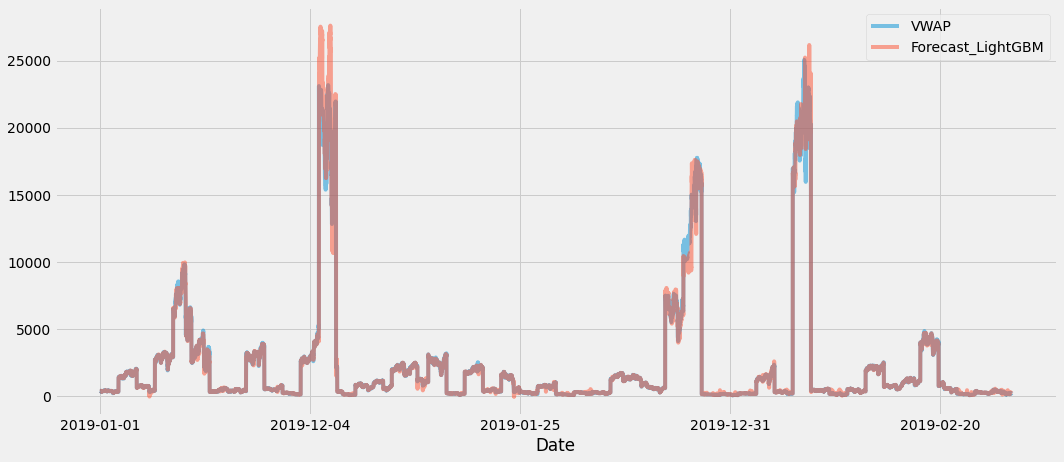

In [44]:
df_valid[["VWAP", "Forecast_LightGBM"]].plot(figsize=(16, 7), alpha = 0.5)

**As we can see, Light GBM has almost predicted the dataset correctly**

In [40]:
import pickle

In [41]:
lgbm = 'lgbm.sav'
pickle.dump(forecast, open(lgbm, 'wb'))

In [42]:
loaded_lgbm = pickle.load(open(lgbm, 'rb'))